<a href="https://colab.research.google.com/github/Youssef889977/ml-advanced-tp1/blob/main/tp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output, State
import dash_bootstrap_components as dbc

try:
    from pickle import load as pickle_load
except Exception:
    pickle_load = None

try:
    import cvxopt as opt
    from cvxopt import solvers
except Exception:
    opt = None
    solvers = None

# ---------- Theming ----------
THEME = dbc.themes.FLATLY  # flat, modern palette
app = Dash(__name__, external_stylesheets=[THEME])
server = app.server

CARD_STYLE = {"borderRadius":"1rem", "boxShadow":"0 8px 24px rgba(0,0,0,0.08)"}
SECTION_PAD = {"padding":"1rem 1.25rem"}

# ---------- Data ----------
DATA_DIR = os.environ.get("DATA_DIR", ".")
INVESTORS_CSV = os.path.join(DATA_DIR, "InputData.csv")
ASSETS_CSV = os.path.join(DATA_DIR, "SP500Data.csv")
MODEL_PATH = os.path.join(DATA_DIR, "finalized_model.sav")

def load_investors():
    if not os.path.exists(INVESTORS_CSV):
        cols = ["AGE07","NETWORTH07","INCOME07","EDCL07","MARRIED07","KIDS07","OCCAT107","RISK07"]
        df = pd.DataFrame([{ "AGE07":25, "NETWORTH07":10000, "INCOME07": 100000, "EDCL07":2,
                             "MARRIED07":1, "KIDS07":0, "OCCAT107":3, "RISK07":3 }], columns=cols)
        return df
    return pd.read_csv(INVESTORS_CSV, index_col=0)

def load_assets():
    if not os.path.exists(ASSETS_CSV):
        dates = pd.date_range("2018-01-01", periods=400, freq="B")
        rng = np.random.default_rng(42)
        df = pd.DataFrame({
            "AAPL": 100 + np.cumsum(rng.normal(0, 1, len(dates))),
            "MSFT": 100 + np.cumsum(rng.normal(0, 1, len(dates))),
            "GOOGL": 100 + np.cumsum(rng.normal(0, 1, len(dates))),
            "META": 100 + np.cumsum(rng.normal(0, 1, len(dates))),
            "GE": 100 + np.cumsum(rng.normal(0, 1, len(dates))),
            "GS": 100 + np.cumsum(rng.normal(0, 1, len(dates))),
            "MS": 100 + np.cumsum(rng.normal(0, 1, len(dates))),
            "AIZ": 100 + np.cumsum(rng.normal(0, 1, len(dates))),
        }, index=dates)
        return df
    df = pd.read_csv(ASSETS_CSV, index_col=0)
    missing_fractions = df.isnull().mean().sort_values(ascending=False)
    drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
    df.drop(labels=drop_list, axis=1, inplace=True)
    df = df.fillna(method="ffill")
    try:
        df.index = pd.to_datetime(df.index)
    except Exception:
        pass
    return df

investors = load_investors()
assets = load_assets()
options = [{"label": tic, "value": tic} for tic in assets.columns]

# ---------- Helpers ----------
def _project_to_simplex(v):
    v = np.asarray(v, dtype=float).ravel()
    n = v.size
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1.0)
    return np.maximum(v - theta, 0)

def mean_variance_pg(mean_ret, cov, lam, iters=700, lr=0.05, w0=None):
    n = mean_ret.shape[0]
    w = np.ones(n)/n if w0 is None else _project_to_simplex(w0)
    for _ in range(iters):
        grad = mean_ret - 2.0 * lam * (cov @ w)
        w = w + lr * grad
        w = _project_to_simplex(w)
    return w

def predict_risk_tolerance(X_input):
    def _as_dataframe(values, feature_names=None):
        import pandas as pd
        if isinstance(values, dict):
            if feature_names is None:
                return pd.DataFrame([values])
            row = {k: values.get(k) for k in feature_names}
            return pd.DataFrame([row], columns=feature_names)
        guess_names = ["AGE07","EDCL07","MARRIED07","KIDS07","OCCAT107","INCOME07","RISK07","NETWORTH07"]
        if feature_names is None:
            return pd.DataFrame(values, columns=guess_names[:len(values[0])])
        row_map = {name: val for name, val in zip(guess_names, values[0])}
        row = [row_map.get(k, 0.0) for k in feature_names]
        return pd.DataFrame([row], columns=feature_names)

    if os.path.exists(MODEL_PATH) and pickle_load is not None:
        try:
            with open(MODEL_PATH, "rb") as f:
                model = pickle_load(f)
            names_expected = getattr(model, "feature_names_in_", None)
            X_df = _as_dataframe(X_input, names_expected)
            pred = np.asarray(model.predict(X_df), dtype=float)
            if pred.max() > 1.5:
                pred = np.clip(pred / 100.0, 0.0, 1.0)
            return float(np.clip(pred[0], 0.0, 1.0))
        except Exception:
            pass

    if isinstance(X_input, dict):
        age = float(X_input.get("AGE07", 30))
        risk4 = float(X_input.get("RISK07", 3))
    else:
        age = float(X_input[0][0])
        risk4 = float(X_input[0][6])
    base = (risk4 - 1) / 3.0
    age_penalty = max(0, (age - 25) / (70 - 25)) * 0.3
    return float(np.clip(base * (1 - 0.2) + (0.2) * (1 - age_penalty), 0.0, 1.0))

def get_asset_allocation(risk_tolerance_0_100, tickers):
    if not tickers:
        raise ValueError("Please select at least one asset.")
    selected = [t for t in tickers if t in assets.columns]
    if not selected:
        raise ValueError("Selected tickers not found in asset data.")
    R = assets.loc[:, selected].pct_change().dropna(axis=0)
    returns = R.T.values
    n = returns.shape[0]
    if n == 0:
        raise ValueError("Not enough data to compute returns.")
    cov = np.cov(returns) + 1e-6 * np.eye(n)
    mean_ret = returns.mean(axis=1)

    rt = float(risk_tolerance_0_100 or 50.0)
    rt01 = np.clip(rt / 100.0, 0.0, 1.0)
    lam = 0.1 + 4.0 * (1.0 - rt01)

    used_solver = "pg"
    w = None

    if opt is not None and solvers is not None:
        try:
            S = opt.matrix(cov)
            pbar = opt.matrix(mean_ret)
            G = -opt.matrix(np.eye(n)); h = opt.matrix(0.0, (n, 1))
            A = opt.matrix(1.0, (1, n)); b = opt.matrix(1.0)
            solvers.options["show_progress"] = False
            sol = solvers.qp(2.0 * lam * S, -pbar, G, h, A, b)
            w = np.array(sol["x"]).reshape(-1)
            used_solver = "cvxopt"
        except Exception:
            w = None
    if w is None:
        w = mean_variance_pg(mean_ret, cov, lam, iters=700, lr=0.05)
        used_solver = "pg"

    alloc = pd.DataFrame(w, index=selected, columns=["weight"])
    weights = w.reshape(-1)
    port_ret = (R.values @ weights)
    cum_value = 100 * (1 + pd.Series(port_ret, index=R.index)).cumprod()
    perf = pd.DataFrame({"Portfolio": cum_value})
    alloc.attrs["solver"] = used_solver
    return alloc, perf

# ---------- UI ----------
def section_header(title, subtitle=None, icon="bar-chart-fill"):
    return html.Div([
        html.Div([
            html.H3(title, className="mb-0"),
            html.P(subtitle, className="text-muted mb-0") if subtitle else html.Span()
        ], style={"padding":"0.5rem 0"})
    ])

# Left controls card
controls = dbc.Card([
    dbc.CardHeader("Step 1 · Investor Characteristics", className="fw-bold"),
    dbc.CardBody([
        dbc.Row([
            dbc.Col([html.Label("Age"), dcc.Slider(id="Age", min=25, max=70, step=1,
                marks={25:"25",35:"35",45:"45",55:"55",70:"70"}, value=25)], width=12)
        ], className="mb-2"),
        dbc.Row([
            dbc.Col([html.Label("Net Worth"), dcc.Slider(id="Nwcat", min=-1000000, max=3000000, step=10000,
                marks={-1000000:"-$1M",0:"0",500000:"$500K",1000000:"$1M",2000000:"$2M"}, value=10000)], width=12)
        ], className="mb-2"),
        dbc.Row([
            dbc.Col([html.Label("Income"), dcc.Slider(id="Inccl", min=-1000000, max=3000000, step=10000,
                marks={-1000000:"-$1M",0:"0",500000:"$500K",1000000:"$1M",2000000:"$2M"}, value=100000)], width=12)
        ], className="mb-2"),
        dbc.Row([
            dbc.Col([html.Label("Education (1–4)"), dcc.Slider(id="Edu", min=1, max=4, step=1,
                marks={1:"1",2:"2",3:"3",4:"4"}, value=2)], width=12)
        ], className="mb-2"),
        dbc.Row([
            dbc.Col([html.Label("Married (1/2)"), dcc.Slider(id="Married", min=1, max=2, step=1,
                marks={1:"1",2:"2"}, value=1)], width=12)
        ], className="mb-2"),
        dbc.Row([
            dbc.Col([html.Label("Kids"), dcc.Slider(id="Kids", min=0, max=6, step=1,
                marks={i:str(i) for i in range(0,7)}, value=0)], width=12)
        ], className="mb-2"),
        dbc.Row([
            dbc.Col([html.Label("Occupation (1–4)"), dcc.Slider(id="Occ", min=1, max=4, step=1,
                marks={1:"1",2:"2",3:"3",4:"4"}, value=3)], width=12)
        ], className="mb-2"),
        dbc.Row([
            dbc.Col([html.Label("Willingness to take Risk (1–4)"),
                     dcc.Slider(id="Risk", min=1, max=4, step=1, marks={1:"1",2:"2",3:"3",4:"4"}, value=3)], width=12)
        ], className="mb-3"),
        dbc.Button("Calculate Risk Tolerance", id="investor_char_button", color="primary", className="w-100")
    ])
], style=CARD_STYLE)

# Right config + charts
right_top = dbc.Card([
    dbc.CardHeader("Step 2 · Asset Selection", className="fw-bold"),
    dbc.CardBody([
        dbc.Row([
            dbc.Col([
                html.Label("Risk Tolerance (0–100)"),
                dcc.Input(id="risk-tolerance-text", type="number", value=50, debounce=True, className="form-control")
            ], md=4),
            dbc.Col([
                html.Label("Select assets"),
                dcc.Dropdown(id="ticker_symbol", options=options,
                             value=["GOOGL","MSFT","GS","MS","GE","AIZ"],
                             multi=True, persistence=True, persistence_type="memory")
            ], md=8)
        ], className="gy-2"),
        dbc.Row([
            dbc.Col(dbc.Button("Submit", id="submit-asset_alloc_button", color="dark", className="mt-2"), width="auto")
        ])
    ])
], style=CARD_STYLE)

charts = dbc.Card([
    dbc.CardBody([
        dbc.Row([
            dbc.Col(dcc.Loading(dcc.Graph(id="Asset-Allocation", config={"displayModeBar": True}), type="dot"), md=6),
            dbc.Col(dcc.Loading(dcc.Graph(id="Performance", config={"displayModeBar": True}), type="dot"), md=6)
        ], className="gy-3")
    ])
], style=CARD_STYLE)

navbar = dbc.Navbar(
    dbc.Container([
        dbc.NavbarBrand("Robo Advisor", className="ms-2 fw-bold"),
        dbc.Nav([
            dbc.NavItem(dbc.NavLink("Dashboard", href="#")),
        ], className="ms-auto", navbar=True)
    ]),
    color="darkblue", dark=True, sticky="top"
)

app.layout = html.Div([
    navbar,
    dbc.Container([
        html.Div(style={"height":"1rem"}),
        dbc.Row([
            dbc.Col(controls, md=4, className="mb-4"),
            dbc.Col([right_top, html.Div(style={"height":"1rem"}), charts], md=8)
        ]),
        html.Div(style={"height":"1rem"}),
        html.Footer(html.Small("© Robo Advisor Demo — built with Dash & Plotly"), className="text-center text-muted mb-4")
    ], fluid=True, className="py-2")
])

# ---------- Callbacks ----------
@app.callback(
    Output("risk-tolerance-text", "value"),
    Input("investor_char_button", "n_clicks"),
    State("Age", "value"),
    State("Nwcat", "value"),
    State("Inccl", "value"),
    State("Risk", "value"),
    State("Edu", "value"),
    State("Married", "value"),
    State("Kids", "value"),
    State("Occ", "value"),
    prevent_initial_call=True,
)
def update_risk_tolerance(n_clicks, Age, Nwcat, Inccl, Risk, Edu, Married, Kids, Occ):
    X_input = [[Age, Edu, Married, Kids, Occ, Inccl, Risk, Nwcat]]
    rt01 = predict_risk_tolerance(X_input)
    return round(float(rt01 * 100), 2)

@app.callback(
    Output("Asset-Allocation", "figure"),
    Output("Performance", "figure"),
    Input("submit-asset_alloc_button", "n_clicks"),
    State("risk-tolerance-text", "value"),
    State("ticker_symbol", "value"),
    prevent_initial_call=True,
)
def update_asset_allocation_chart(n_clicks, risk_tolerance, stock_ticker):
    try:
        alloc, perf = get_asset_allocation(risk_tolerance, stock_ticker)
    except Exception as e:
        empty1 = go.Figure()
        empty1.update_layout(template="plotly_white",
                             title=f"Asset allocation - Error: {str(e)}",
                             margin=dict(l=40,r=20,t=60,b=40))
        empty2 = go.Figure()
        empty2.update_layout(template="plotly_white",
                             title="Portfolio value of $100 investment",
                             margin=dict(l=40,r=20,t=60,b=40))
        return empty1, empty2

    fig_alloc = go.Figure()
    fig_alloc.add_bar(x=alloc.index, y=alloc["weight"])
    fig_alloc.update_layout(
        template="plotly_white",
        title=f"Asset allocation - Mean-Variance Allocation ({alloc.attrs.get('solver','pg')})",
        xaxis_title="Ticker", yaxis_title="Weight",
        yaxis_tickformat=".0%",
        #margin=dict(l=40,r=20,t=60,b=40),
        hovermode="x unified"
    )

    fig_perf = go.Figure()
    fig_perf.add_scatter(x=perf.index, y=perf["Portfolio"], mode="lines", name="Portfolio")
    fig_perf.update_layout(
        template="plotly_white",
        title="Portfolio value of $100 investment",
        xaxis_title="Date", yaxis_title="Value ($)",
        #margin=dict(l=40,r=20,t=60,b=40),
        hovermode="x unified"
    )

    return fig_alloc, fig_perf

if __name__ == "__main__":
    port = int(os.environ.get("PORT", "8080"))
    app.run(host="0.0.0.0", port=port, debug=False)


ModuleNotFoundError: No module named 'dash'

In [2]:
pip install pandas scikit-learn matplotlib seaborn streamlit --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 129.3 MB/s eta 0:00:00


In [15]:
# !pip install pandas scikit-learn matplotlib seaborn streamlit --quiet
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
# Modeling
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [16]:
# Regressors
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [21]:
DATAFILE = Path("/content/SCFP2009panel.xlsx")
assert DATAFILE.exists(), "Put SCFP2009panel.xlsx in this folder."


In [22]:
dataset = pd.read_excel(DATAFILE)
dataset.shape, type(dataset)

((19285, 515), pandas.core.frame.DataFrame)

In [24]:
dataset.head(3)

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I
0,1,11,11668.134198,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,270.403054,57
1,1,12,11823.456494,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,249.593620,57
2,1,13,11913.228354,47,3,12,2,1,0,2,...,-50.000000,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,209.233358,57


In [ ]:
dataset.head(3).to_csv('dataset_head3.csv', index=False, encoding='utf-8')
from google.colab import files
files.download('dataset_head3.csv')


# 1 -- on a 3 lignes et 515 colonnes (3 rows and 515 columns)
# 2 -- A single row appears to represent one household/customer profile tracked across time

# 3 -- If your model must be trained using only 2007 information to predict an outcome, then any variable that includes post‑2007 information will leak future knowledge and should be excluded


In [29]:
# PART 2

#Average SP500 during 2007 and 2009
# used to normalize 2009 risky assets
Average_SP500_2007=1478
Average_SP500_2009=948

# Risk-free and risky assets (2007)
dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07']
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])

# Risk-free and risky assets (2009)
dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09']
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)
dataset2 = copy.deepcopy(dataset)
dataset2['PercentageChange'] = np.abs(dataset2['RT09']/dataset2['RT07']-1)
dataset2.head()

# dealing with missing values

#Checking for any null values and removing the null values'''
print('Null Values =',dataset2.isnull().values.any())
# Drop the rows containing NA
dataset2=dataset2.dropna(axis=0)

dataset2=dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

#Checking for any null values and removing the null values'''
print('Null Values =',dataset2.isnull().values.any())
dataset2.shape





Null Values = True
Null Values = False


(7956, 522)

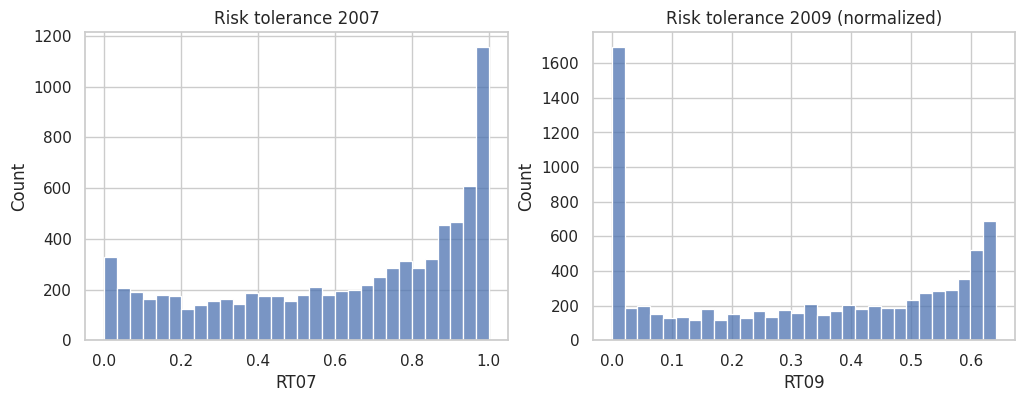

In [30]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(dataset2["RT07"].clip(0,1), bins=30, ax=axes[0])
axes[0].set_title("Risk tolerance 2007")
sns.histplot(dataset2["RT09"].clip(0,1), bins=30, ax=axes[1])
axes[1].set_title("Risk tolerance 2009 (normalized)")
plt.show()


In [33]:
dataset3 = copy.deepcopy(dataset2)
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09'])/2
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

In [34]:
dataset3

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RiskFree09,Risky09,TrueRiskTolerance
5,2,21,255.421402,56,4,17,4,1,2,5,...,0.0,0.0,-51.718701,131.926121,57,337604.833440,1.387701e+06,230000,350000,0.595689
6,2,22,265.151248,56,4,17,4,1,2,5,...,0.0,0.0,-51.718701,131.926121,57,337604.833440,1.480905e+06,230000,350000,0.600703
7,2,23,254.044527,56,4,17,4,1,2,5,...,0.0,0.0,-51.718701,131.926121,57,337604.833440,1.164012e+06,230000,350000,0.581114
8,2,24,252.877840,56,4,17,4,1,2,5,...,0.0,0.0,-51.718701,131.926121,57,337604.833440,2.489577e+06,230000,350000,0.633821
9,2,25,245.023339,56,4,17,4,1,2,5,...,0.0,0.0,-51.718701,131.926121,57,337604.833440,1.862005e+06,230000,350000,0.616786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19275,4422,44221,3874.898275,39,2,17,4,1,7,3,...,0.0,0.0,-43.198471,-55.505941,57,111740.986284,2.796114e+04,92900,29000,0.176370
19276,4422,44222,3826.617616,39,2,17,4,1,7,3,...,0.0,0.0,-25.721078,-53.759912,57,118058.131940,3.313912e+04,83300,30000,0.194506
19277,4422,44223,3590.273355,39,2,17,4,1,7,3,...,0.0,0.0,-31.026715,-51.064850,57,176051.600261,4.660189e+04,95600,25000,0.171132
19278,4422,44224,4346.549054,39,2,17,4,1,7,3,...,0.0,0.0,-51.718701,-46.853831,57,112673.024167,5.074428e+04,63100,27000,0.251364


1. What business behavior does “PercentageChange ≤ 10%” capture?
La condition “PercentageChange ≤ 10%” (variation ≤ 10%) capture les clients ou ménages dont la variable étudiée (par exemple, patrimoine, dette, revenu…) est restée stable entre deux périodes (ici 2007 et 2009).
En business, cela signifie :

Comportement stable : Le client n’a pas pris de décisions majeures (pas de gros investissement, pas de désinvestissement, pas de changement de situation financière brutal).
Fidélité ou prudence : Souvent, ces clients sont considérés comme prudents, fidèles à leur stratégie, ou peu exposés aux chocs économiques.
Cible pour offres “conservatrices” : Ils peuvent être ciblés par des produits à faible risque ou des offres de fidélisation.



2. Why do we clip risk tolerance to [0,1]?
La tolérance au risque (“risk tolerance”) est une variable qui, par définition, doit être comprise entre 0 (aversion totale au risque) et 1 (appétit maximal pour le risque).
On “clippe” à [0,1] pour :

Respecter le domaine de définition : Empêcher des valeurs aberrantes (négatives ou >1) qui n’ont pas de sens business.
Éviter les biais statistiques : Les valeurs hors bornes peuvent fausser les analyses, les modèles ou les visualisations.
Uniformiser l’interprétation : 0 = très prudent, 1 = très risqué, ce qui facilite la segmentation et la communication.


3. Looking at the two histograms, what crisis-era behavioral shift do you observe?
Description des histogrammes :

Gauche (2007) : Distribution de la tolérance au risque avant la crise.

Beaucoup de clients à 0 (très prudents) et un pic massif à 1 (très risqués).
Distribution “en U” : beaucoup d’extrêmes, moins de profils intermédiaires.


Droite (2009, normalisé) : Distribution après la crise financière.

Pic très accentué à 0 (encore plus de prudents).
Le pic à 1 a disparu : la tolérance maximale au risque n’existe plus.
La distribution est “tirée vers le bas” : la majorité des clients sont devenus très prudents.

In [12]:
pip install dash-core-components



SyntaxError: invalid syntax (ipython-input-3582120581.py, line 1)